**Student: HO Quang Phuoc, Master MVA, ENS Paris-Saclay**

## Contrastive pre-training

Here, we will try the SimCLR method.

[1] T. Chen et al. “A Simple Framework for Contrastive Learning of Visual Representations”. In: ICML. 2020.


In [1]:
import os
import shutil
import yaml
import logging
import sys
import zipfile
from copy import deepcopy


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

## Torchvision
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.datasets import STL10, PCAM
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn

## Plot Options
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
plt.set_cmap("cividis")
%matplotlib inline
sns.set_theme()

## SKlearn
from sklearn.linear_model import LogisticRegression


# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
print("Number of workers:", NUM_WORKERS)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)


Number of workers: 4


<Figure size 640x480 with 0 Axes>

In [15]:
# Environment flags
IN_KAGGLE = True
IN_COLAB = False
HFACTORY = False

# Install dependencies based on the environment
if IN_COLAB:
    try:
        import google.colab
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
        # Install gdown in Colab
        !pip install gdown==4.6.0
        import gdown

elif HFACTORY:
    # Install gdown and h5py in Hfactory
    !pip install gdown==4.6.0
    !pip uninstall -y h5py
    !pip install h5py
    import h5py

else:  # IN_KAGGLE
    # Import gdown in Kaggle
    import gdown

In [ ]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found.")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")  # we use one GPU, the first one
    print("CUDA device found.")
else:
    device = torch.device("cpu")
    print("No MPS or CUDA has been found. PyTorch will use CPU.")

Using torch 2.5.1+cu121
CUDA device found.


### Data Augmentation for Contrastive Learning

One of the key points of SimCLR is the choice of the augmentation strategy. It composes many different geometric and iconographic transformations.
We can implement them very efficiently and easily using the Dataset object of Pytorch.

Since in SimCLR authors use 2 views, we do the same here. Please note that we could use more positives

The transformations used are: (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_data_augmentations.jpg" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

When using ImageNet-derived datasets, the two most important transformations are: crop-and-resize, and color distortion.
Interestingly, they need to be used together since, when combining randomly cropping and resizing, we might have two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in the representation space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view.
However, the network can use the color information (color histograms) to create a useless link between the two patches, without learning generalizable high-level representations. For instance, it could focus on the color of the fur of the dog and on the color of the background to understand that the two patches belong to the same image. That's why, we need to compose crop-and-resize and color distortion.

**Question**: Create a Pytorch class of transformations (transforms.Compose) where you apply the following augmentations:
- Resize an Crop
- Horizontal Flip
- Color jittering
- Gray scale changes
- Gaussian Blur

Hint: all functions have already been implemented and can be found here: https://pytorch.org/vision/0.9/transforms.html

Alternatively, you can also use [albumentations](https://albumentations.ai/) by simply adding:

`import albumentations as A`

`from albumentations.pytorch.transforms import ToTensorV2`

In [ ]:
class ContrastiveTransformations:
    def __init__(self, img_size, s=1):
        # Transformations applied in SimCLR article
        self.s = s
        self.data_transform = transforms.Compose(
            [
                # Cropped area is at least 20% and at most 100% of the original
                # The cropped image is then resized to the original image
                transforms.RandomResizedCrop(size=img_size, scale=(0.2, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [
                        transforms.ColorJitter(
                            brightness=0.8 * s,
                            contrast=0.8 * s,
                            saturation=0.8 * s,
                            hue=0.2 * s,
                        )
                    ],
                    p=0.8,
                ),
                transforms.RandomGrayscale(p=0.2),
                transforms.GaussianBlur(kernel_size=int(0.1 * img_size)),
                transforms.ToTensor(),
                # Normalize with ImageNet statistics
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    def __call__(self, x):
        view1 = self.data_transform(x)
        view2 = self.data_transform(x)
        # it outputs a tuple, namely 2 views (augmentations) of the same image
        return view1, view2

In [ ]:
# simple transformation to use networks pre-trained on ImageNet
img_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

**Question**: What's the difference between `ContrastiveTransformations` and `img_transforms` ? Look inside the functions and their outputs...

**Answer:** Here `ConstrastiveTransformations` generates two augmented views of the same image to encourage the model the learn invariant and generalizable features. Particularly, the transformation applies many augmentations, such as random cropping, color jitter, to ensure the model focuses on high-level semantic features rather than low-level information like color or texture.

On the other hand, `img_transforms` acquires a simple preprocessing for images. It converts an image to a tensor and normalizes the image using ImageNet statistics, and does not apply any data augmentation or generate multiple views.

In [ ]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

In [ ]:
if IN_COLAB:
    # data_directory="./" # decomment it if you do NOT use Google Drive
    data_directory = "/content/drive/MyDrive/TP/"  # decomment it if you USE Google Drive and copy/paste the path to your Google Drive
elif HFACTORY:
    data_directory = "./"
else:  # IN_KAGGLE
    data_directory = "/kaggle/input/stl10-dataset/data/"  # copy/paste the path of the folder with STL dataset in your computer

print(f"data dir: {data_directory}")

data dir: /kaggle/input/stl10-dataset/data/


We create unlabeled, training and test Datasets.
Please be careful since we use two different transformations, one for the unlabelled part and one for train/test set.

In [ ]:
unlabeled_dataset_2viewsCon = STL10(
    root=data_directory + "stl10_binary",
    split="unlabeled",
    download=False,
    transform=ContrastiveTransformations(96),
)
train_dataset = STL10(
    root=data_directory + "stl10_binary",
    split="train",
    download=False,
    transform=img_transforms,
)
# just to show the effect of the augmentations and the classes
train_dataset_2viewsCon = STL10(
    root=data_directory + "stl10_binary",
    split="train",
    download=False,
    transform=ContrastiveTransformations(96),
)
test_dataset = STL10(
    root=data_directory + "stl10_binary",
    split="test",
    download=False,
    transform=img_transforms,
)

In [ ]:
# To check the classes in STL10
classes = unlabeled_dataset_2viewsCon.classes
print(classes)
print("Number images in Unlabeled dataset:", len(unlabeled_dataset_2viewsCon))
print(
    unlabeled_dataset_2viewsCon[0][0][0].shape
)  # this is one image (the first of the 2-views tuple)

# Train dataset
labels = train_dataset.labels  # retrieve label of each sample
print(
    "Number images in Train dataset:", len(train_dataset)
)  # retrieve length of dataset
print(train_dataset[3][0].shape)  # this is one image

# Test dataset
print("Number images in Test dataset:", len(test_dataset))
print(test_dataset[0][0].shape)  # this is one image

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Number images in Unlabeled dataset: 100000
torch.Size([3, 96, 96])
Number images in Train dataset: 5000
torch.Size([3, 96, 96])
Number images in Test dataset: 8000
torch.Size([3, 96, 96])


The Unlabeled dataset contains 100k images. Here, to limit memory requirement, we will use 10% of the data.

In [ ]:
sizeUnlabelled = 5000

unlabeled_dataset_2viewsCon_red, rest = random_split(
    unlabeled_dataset_2viewsCon,
    [sizeUnlabelled, len(unlabeled_dataset_2viewsCon) - sizeUnlabelled],
)
print(len(unlabeled_dataset_2viewsCon_red))
del unlabeled_dataset_2viewsCon  # free memory

5000


We can also create a function to visualize the views of each sample, based on the chosen augmentation strategy.

In [ ]:
def imshowSTL102views(datasetOrig, datasetTransform, rows=5, figsize=(8, 15)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, 3 * (rows - 1) + 2, 3):
        imgOrig = datasetOrig[i][0]
        img1 = datasetTransform[i][0][0]
        img2 = datasetTransform[i][0][1]

        # REMOVE NORMALIZATION
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
        # Clip values to range [0,1] -> possible rounding errors during normalization
        imgOrig = np.clip(unnormalize(imgOrig).numpy(), 0, 1)
        img1 = np.clip(unnormalize(img1).numpy(), 0, 1)
        img2 = np.clip(unnormalize(img2).numpy(), 0, 1)

        label = datasetOrig[i][1]
        fig.add_subplot(rows, 3, i)
        plt.title(datasetOrig.classes[label] + " , original")
        plt.imshow(np.transpose(imgOrig, (1, 2, 0)))
        plt.axis("off")
        fig.add_subplot(rows, 3, i + 1)
        plt.title(datasetOrig.classes[label] + " , 1st view")
        plt.imshow(np.transpose(img1, (1, 2, 0)))
        plt.axis("off")
        fig.add_subplot(rows, 3, i + 2)
        plt.title(datasetOrig.classes[label] + " , 2nd view")
        plt.imshow(np.transpose(img2, (1, 2, 0)))
        plt.axis("off")
    plt.show()

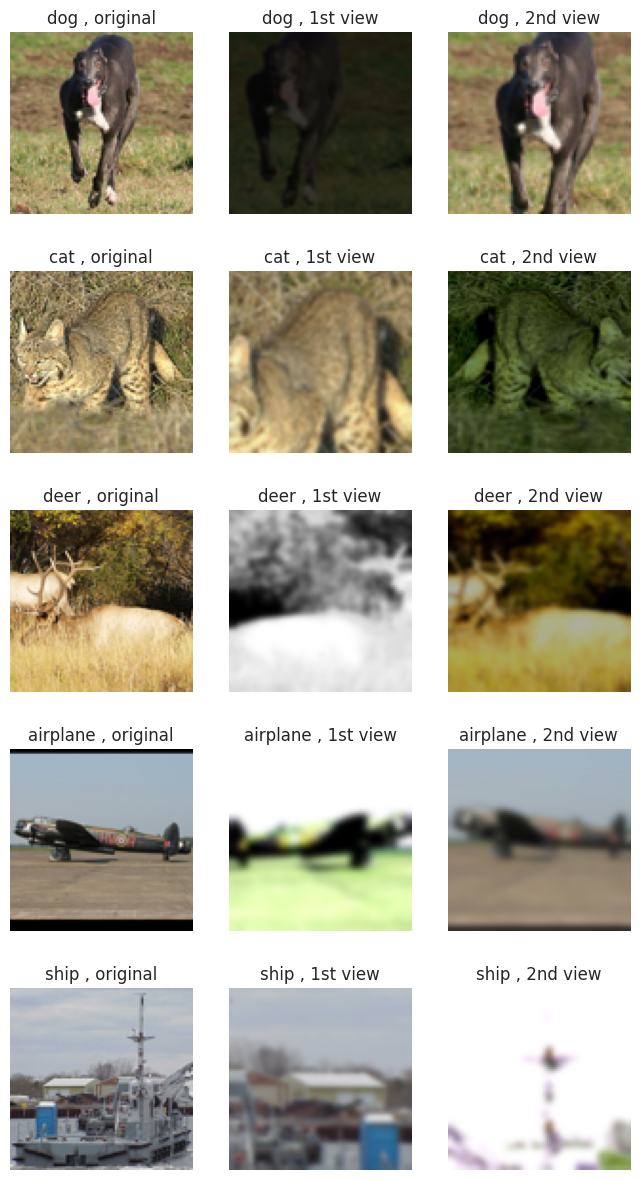

In [ ]:
imshowSTL102views(train_dataset, train_dataset_2viewsCon)

In [ ]:
del train_dataset_2viewsCon  # To free memory

Here, it's the most important part of the code.

I remind you that the Siamese architecture of SimCLR is: (figure credit - [Ting Chen et al. ](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/13-contrastive-learning/simclr_network_setup.svg" width="350px"></center>

The employed loss is the InfoNCE loss:
$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$
where $\tau$ is the temperature and the similarity measure is the cosine similarity:
$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$
The maximum cosine similarity possible is $1$, while the minimum is $-1$.

After training, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor.


**Question**: Comment the code where you see **XXXXXXXXXXXXXXXXXX** explaining in details what the code is doing.

PS: if you are using a MacBook, you might have issues with multiprocessing. In that case, please use Google Colab.

**Answer:** Below I add some comments explaining each line of code.

In [ ]:
class SimCLR:

    def __init__(
        self, model, optimizer, scheduler, device, batch_size, temperature, epochs
    ):
        self.device = device

        # Ultilize 2 GPU in Kaggle
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs!")
            model = nn.DataParallel(model)

        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.temperature = temperature
        self.batch_size = batch_size
        self.epochs = epochs

    def info_nce_loss(self, features):

        # Create labels for the constrastive loss
        labels = torch.cat(
            [torch.arange(self.batch_size) for i in range(2)], dim=0
        )  # [0,...,batch_size-1, 0,..., batch_size-1]
        labels = (
            labels.unsqueeze(0) == labels.unsqueeze(1)
        ).float()  # Shape batch_size * batch_size
        labels = labels.to(self.device)

        # Normalize the feature vectors to have unit length
        features = F.normalize(features, dim=1)

        # Compute the similarity matrix using dot products
        similarity_matrix = torch.matmul(features, features.T)

        # Remove self-similarity (diagonal elements) from the similarity_matrix and labels
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(
            self.device
        )  # Identidy matrix batch_size * batch_size
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(
            similarity_matrix.shape[0], -1
        )

        # Get the positive pairs
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # Get the negative pairs
        negatives = similarity_matrix[~labels.bool()].view(
            similarity_matrix.shape[0], -1
        )

        # Concatenate positive and negative pairs
        logits = torch.cat([positives, negatives], dim=1)

        # Create ground truth for contrastive loss
        # The first column (positive) is the correct class, and the rest are negative
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        # Scale the logits by the temperature parameter
        logits = logits / self.temperature
        return logits, labels

    def train(self, train_loader, use_amp=False):

        # Initialize the GradScaler if using mixed-precision training
        scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None

        n_iter = 0
        print("Start SimCLR training for {} epochs.".format(self.epochs))

        for epoch_counter in range(self.epochs):
            for images, _ in tqdm(train_loader):
                # Concatenate the two augmented views of the images into a single batch
                # Shape (2*batch_size, C, H, W)
                images = torch.cat(images, dim=0)
                images = images.to(self.device)
                # print(f"cuda: {torch.cuda.is_available()}, use_amp: {use_amp}")

                if torch.cuda.is_available() and use_amp:
                    # print("GPU is active")
                    with torch.autocast(
                        device_type="cuda", dtype=torch.float16, enabled=use_amp
                    ):  # to improve performance while maintaining accuracy.
                        features = self.model(images)
                        logits, labels = self.info_nce_loss(features)
                        loss = self.criterion(logits, labels)
                else:  # autocast and mixed-precision training with FP16 is not suited for CPU
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    # Compute the cross-entropy loss
                    loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()

                if scaler is not None:
                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    self.optimizer.step()

                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 5:
                self.scheduler.step()

            print(
                "Epoch: {}, Average loss: {:.4f}, lr: {:.4f}".format(
                    epoch_counter,
                    loss / len(train_loader.dataset),
                    self.scheduler.get_last_lr()[0],
                )
            )

        print("Training has finished.")

As before, we use a DataLoader.

DataLoader wraps an iterable around the Dataset to enable easy access to the samples. The Dataset retrieves our dataset features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.


In [ ]:
bs = 128  # choose an appropriate batch size depending on the computational resources

train_unlabelled_loader = DataLoader(
    dataset=unlabeled_dataset_2viewsCon_red,
    batch_size=bs,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True,
)

Here we define the hyper-parameters, optimization, scheduler and launch the training.

**Question**: complete the code where you see XXXXX.

As model for $f()$, use a ResnNet18 not-pretrained. Remember that the model ResNet18 has already a Linear Layer at the end (fc) which can be written as $Wf(x)$. You can also change the `out_features` of the fc by adding the option `num_classes=XXXX` while loading the model.

 As projection head, use the one from the article

 $$ g(f(x))=W^a \sigma (W^b f(x))$$

 where $\sigma$ is a Relu non-linearity.

**Answer:** Below is my implementation. I use ResNet18 as the encoder `f`, without pretraining. The projection `g` includes 2 dense layers.

In [ ]:
max_epochs = 2
lr = 0.003
wd = 1e-4
temperature = 0.07
f_dim = 512  # to use if you want to change the output dimension of f
g_dim = 128  # the output dimension of the projection head

# Ensure that you are using GPU and all CPU workers
print("Device:", device)

# Encoder f
f = models.resnet18(pretrained=False)  # Wf()

# Projection head g()
g = nn.Sequential(
    nn.Linear(f_dim, f_dim), nn.ReLU(inplace=True), nn.Linear(f_dim, g_dim)
)

f.fc = g


optimizer = torch.optim.Adam(f.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=len(train_unlabelled_loader), eta_min=0, last_epoch=-1
)

Device: cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
simclr = SimCLR(
    model=f,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    batch_size=bs,
    temperature=temperature,
    epochs=max_epochs,
)

if torch.cuda.is_available():
    simclr.train(train_unlabelled_loader, use_amp=True)
else:
    simclr.train(train_unlabelled_loader, use_amp=False)

# save model checkpoints
os.makedirs("models/", exist_ok=True)
filename = "models/resnet18_simclr_2epochs_stl10.pth.tar"
torch.save({"epoch": max_epochs, "state_dict": simclr.model.state_dict()}, filename)

<ipython-input-27-62894c914d75>:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if torch.cuda.is_available() else None


Start SimCLR training for 2 epochs.


100%|██████████| 39/39 [00:18<00:00,  2.06it/s]


Epoch: 0, Average loss: 0.0011, lr: 0.0030


100%|██████████| 39/39 [00:15<00:00,  2.49it/s]


Epoch: 1, Average loss: 0.0011, lr: 0.0030
Training has finished.


To continue, you can use a model that I have already pre-trained for 100 epochs.

In [ ]:
pretrained_model_path_dir = "/kaggle/input/resnet18-simclr-100epochs-stl10/"
model_path = "resnet18_simclr_50epochs_stl10.pth.tar"

if os.path.isfile(pretrained_model_path_dir + model_path):
    print("pre-trained model already downloaded")
else:
    print("downloading the pre-trained model")
    os.makedirs(pretrained_model_path_dir + "models/", exist_ok=True)
    file_url = "https://drive.google.com/uc?id=13_ZueA9mqh17GvYVkfU_Yokg3z065rKG"
    gdown.download(file_url, data_directory + model_path)


# Load checkpoint file of already trained model
checkpoint = torch.load(
    pretrained_model_path_dir + model_path, map_location=torch.device(device)
)

# Load Model parameters and set it into eval mode
model_download = models.resnet18(weights=None)  # we will only use f and not g
model_download.load_state_dict(checkpoint["state_dict"], strict=False)

epoch = checkpoint["epoch"]

pre-trained model already downloaded


<ipython-input-31-dfadca2fe6c1>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_model_path_dir+model_path, map_location=torch.device(dev

As previously explained, we can now use $f()$ to encode the samples discarding $g()$.

**Question** How can you discard the projection ? Complete the code.

**Answer:** I discard the projection `g` by convert the `network.fc` to a Identity layer.

In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataset, batchsize, device):
    # Prepare model
    network = deepcopy(model)

    # you need to modify network here
    network.fc = nn.Identity()  # Discard the projection g

    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(
        dataset,
        batch_size=batchsize,
        num_workers=NUM_WORKERS,
        shuffle=False,
        drop_last=False,
    )

    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels), [feats.numpy(), labels.numpy()]

We can use either the trained model or the downloaded model and encode the train and test images.

In [ ]:
# modelTrained=simclr.model
modelTrained = model_download
trainloader, [train_feats, train_labels] = prepare_data_features(
    modelTrained, train_dataset, batchsize=256, device=device
)
testloader, [test_feats, test_labels] = prepare_data_features(
    modelTrained, test_dataset, batchsize=256, device=device
)
print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

100%|██████████| 32/32 [00:02<00:00, 11.11it/s]


(5000, 512) (5000,)
(8000, 512) (8000,)


**Linear Probe**:  we train a logistic regression on the train dataset and evaluate it on the test dataset. This is called Linear Probe.

**Question**: compute the training and test errore using a logistic regression where you are free to use a regularization.

**Answer:** I implement `linear_probe` function to train a logistic regression (with default `regularization_strength=1`, `max_iter=1000`) on the train dataset and evaluate it on the test dataset.

In [ ]:
# compute linear probe results
from sklearn.metrics import accuracy_score


def linear_probe(
    train_features,
    train_labels,
    test_features,
    test_labels,
    regularization_strength=1.0,
):
    """
    Perform linear probing using logistic regression.

    Args:
        train_features: Features of the training set, shape: [num_train_samples, feature_dim]
        train_labels: Labels of the training set, shape: [num_train_samples]
        test_features: Features of the test set, shape: [num_test_samples, feature_dim]
        test_labels: Labels of the test set, shape: [num_test_samples]
        regularization_strength: Regularization strength C

    Returns:
        train_error (float): Training error (1 - accuracy).
        test_error (float): Test error (1 - accuracy).
    """
    log_reg = LogisticRegression(
        C=regularization_strength, max_iter=1000, random_state=666
    )
    log_reg.fit(train_features, train_labels)

    # Predict on the training set
    train_preds = log_reg.predict(train_features)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_error = 1 - train_accuracy

    # Predict on the test set
    test_preds = log_reg.predict(test_features)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_error = 1 - test_accuracy

    return train_error, test_error

In [ ]:
# Perform linear probing
regularization_strength = 1.0
train_error, test_error = linear_probe(
    train_feats, train_labels, test_feats, test_labels, regularization_strength
)

print(f"Training Error: {train_error:.4f}")
print(f"Test Error: {test_error:.4f}")

Training Error: 0.3808
Test Error: 0.5002


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


What if we simply used it a pre-trained model on ImageNet ? ...

**Question**: use the previous function `prepare_data_features` with a resnet18 pre-trained on Imagenet and compute the Linear Probe as before.

**Answer:** Below I use `prepare_data_features` with a ResNet18 model pretrained on ImageNet, then I compute the Linear Probe.

In [ ]:
modelImageNet = models.resnet18(pretrained=False)
modelImageNet.load_state_dict(torch.load("/kaggle/input/resnet18/resnet18.pth"))

trainloader, [train_feats, train_labels] = prepare_data_features(
    modelImageNet, train_dataset, batchsize=256, device=device
)
testloader, [test_feats, test_labels] = prepare_data_features(
    modelImageNet, test_dataset, batchsize=256, device=device
)
print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-36-2d3b0bbcf0ee>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

(5000, 512) (5000,)
(8000, 512) (8000,)


In [ ]:
# Perform linear probing
regularization_strength = 1.0
train_error, test_error = linear_probe(
    train_feats, train_labels, test_feats, test_labels, regularization_strength
)

print(f"Training Error: {train_error:.4f}")
print(f"Test Error: {test_error:.4f}")

Training Error: 0.0000
Test Error: 0.1360


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Question**: is the result better ? Why in your opinion ? What could you do to improve the method with the worst result ?



**Answer:** We have two methods with the following performance:

| Method                          | Training Error | Test Error |
|---------------------------------|----------------|------------|
| SimCLR-trained ResNet18 (1)     | 0.3808         | 0.5002     |
| Pre-trained ResNet18 on ImageNet (2) | 0.0000      | 0.1360     |

(2) achieves lower training and test errors because the model has already learned useful features from ImageNet, which is a large and diverse dataset. These features are likely to be more generalized and discriminative.

(1) achieves higher training and test errors compared to (2). This could be caused by some reasons. First, in (1) the self-supervised traninig was done on a small dataset (STL10), the model may not have learned as generalizable features as the ImageNet-pretrained model.
Second, training in (1) is more complex. If the training is not done properly (not enough epochs, suboptimal hyperparameters), the resulting features may not be as good.

Here I proposed some ways to improve the results:
- Use a larger dataset for self-supervised training
- Increase the number of epochs
- Improve data augmentations (stronger and more diverse)
- Use a larger model (ResNet50, ResNet101)
- Hyperparameter tuning


To go further, you could use one of the datasets present in Med Mnist (https://medmnist.com/). These are real but rescaled images. Small images allow the training of DL models on small GPU but we loose resolution and thus clinically relevant information. 

Otherwise, you could use the PatchCamelyon dataset (https://www.kaggle.com/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon), which comprises real and large images.

The PatchCamelyon benchmark is a image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue.

You can donwload it from pytorch vision or, if you are using Google Colab, directly from our Google drive. The pytorch version needs to be unzipped and there is not enough RAM memory in the Google Colab servers...

Please do not change the following code.

In [ ]:
# Data directory for PatchCamelyon dataset
data_directory = "/kaggle/input/pcam-resource/"

In [ ]:
os.makedirs(data_directory + "pcam", exist_ok=True)

# Download the Train set
file_url = "https://drive.google.com/uc?id=1ipIG12YWag54v2_2JIyfPiZDN0Eu3IjB"
train_path = "training_split.h5"
if os.path.isfile(data_directory + "pcam/" + train_path):
    print("training set already downloaded")
else:
    print("downloading training set")
    gdown.download(file_url, data_directory + "pcam/" + train_path, quiet=False)

training set already downloaded


In [ ]:
# Download Valid set
file_url = "https://drive.google.com/uc?id=1emdhTV8J8Pv-SjKSoMzE_SbT04Ik2yUm"
valid_path = "validation_split.h5"
if os.path.isfile(data_directory + "pcam/" + valid_path):
    print("validation set already downloaded")
else:
    print("downloading validation set")
    gdown.download(file_url, data_directory + "pcam/" + valid_path, quiet=False)

validation set already downloaded


In [ ]:
# Download Test set
file_url = "https://drive.google.com/uc?id=1dkeFapKSKm-wUtf9zicxiSHWIS0uxv8Z"
test_path = "test_split.h5"
if os.path.isfile(data_directory + "pcam/" + test_path):
    print("test set already downloaded")
else:
    print("downloading test set")
    gdown.download(file_url, data_directory + "pcam/" + test_path, quiet=False)

test set already downloaded


In [ ]:
# Download the labels
file_url = "https://drive.google.com/uc?id=10ftBj2ZiiDESTsANdF-v8oh4NieinYPP"
labels_path = "Label.zip"
if os.path.isfile(
    data_directory + "pcam/Labels/Labels/camelyonpatch_level_2_split_test_y.h5"
):
    print("Labels already downloaded")
else:
    print("downloading labels")
    gdown.download(file_url, data_directory + "pcam/" + labels_path, quiet=False)
    # Unzip and move to data directory
    with zipfile.ZipFile(data_directory + "pcam/" + labels_path, "r") as zip_ref:
        zip_ref.extractall(data_directory + "pcam/")
    # Moving files
    os.rename(
        data_directory + "pcam/Labels/camelyonpatch_level_2_split_test_y.h5",
        data_directory + "pcam/camelyonpatch_level_2_split_test_y.h5",
    )
    os.rename(
        data_directory + "pcam/Labels/camelyonpatch_level_2_split_train_y.h5",
        data_directory + "pcam/camelyonpatch_level_2_split_train_y.h5",
    )
    os.rename(
        data_directory + "pcam/Labels/camelyonpatch_level_2_split_valid_y.h5",
        data_directory + "pcam/camelyonpatch_level_2_split_valid_y.h5",
    )
    # Cleaning
    os.remove(data_directory + "pcam/" + labels_path)
    os.rmdir(data_directory + "pcam/Labels")

Labels already downloaded


Now you can load it using the PCAM Dataset and DataLoader (keep download as False since you have already downloaded the data)

In the following, you will use the training split as if it was unlabeled, thus for the self-supervised part, then the val split as if it was the training set and the test split as test set.

In [ ]:
img_size = 96
bs = 128

# PCAM Dataset
PCAM_unlabeled_dataset = PCAM(
    root=data_directory,
    download=False,
    split="train",
    transform=ContrastiveTransformations(img_size),
)
PCAM_train_dataset = PCAM(
    root=data_directory, download=False, split="val", transform=transforms.ToTensor()
)
PCAM_test_dataset = PCAM(
    root=data_directory, download=False, split="test", transform=transforms.ToTensor()
)
print(
    "There are: ",
    len(PCAM_unlabeled_dataset),
    "training images; ",
    len(PCAM_train_dataset),
    " validation images; and ",
    len(PCAM_test_dataset),
    " test images",
)

PCAM_unlabeled_loader = DataLoader(
    dataset=PCAM_unlabeled_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True
)
PCAM_train_loader = DataLoader(PCAM_train_dataset, batch_size=bs)
PCAM_test_loader = DataLoader(PCAM_test_dataset, batch_size=bs)

There are:  262144 training images;  32768  validation images; and  32768  test images


We can visualize the images as before

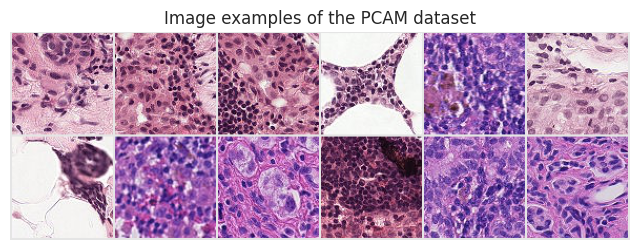

In [ ]:
# Visualize some examples
NUM_IMAGES = 12
PCAM_images = torch.stack(
    [
        PCAM_train_dataset[np.random.randint(len(PCAM_train_dataset))][0]
        for idx in range(NUM_IMAGES)
    ],
    dim=0,
)
img_grid = torchvision.utils.make_grid(
    PCAM_images, nrow=6, normalize=True, pad_value=0.9
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the PCAM dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

**Question**: As before, train the SimCLR algorithm on the unlabeled set and then train and test the Linear Probe.

This time, you can use the ResNet-18 pre-trained on ImageNet and train it for just 10 epochs.
If you want to speed up the computations (a bit) you can also reduce the size of the images


**Answer:** Below I train ResNet18, without pretrained, using full PCAM Dataset for 10 epochs. For a limitation in GPUs usage, I train it separately and load the checkpoint.

In [81]:
# Check the number of available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Number of GPUs available: 2
GPU 0: Tesla T4
GPU 1: Tesla T4


In [ ]:
max_epochs = 10
lr = 0.003
wd = 1e-4
temperature = 0.07


model = models.resnet18(weights=None, num_classes=128)
dim_mlp = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), model.fc)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=len(PCAM_unlabeled_loader), eta_min=0, last_epoch=-1
)

pretrain_model_path = "/kaggle/input/resnet18-pcam/resnet18_simclr_10epochs_PCAM.pth"

try:
    # Load checkpoint file of already trained model
    checkpoint = torch.load(pretrain_model_path, map_location=torch.device(device))
    print("Checkpoint loaded successfully")

    # Load Model parameters and set it into eval mode
    model_download = models.resnet18(weights=None)  # we will only use f and not g
    model_download.load_state_dict(checkpoint["state_dict"], strict=False)

    epoch = checkpoint["epoch"]

except FileNotFoundError:
    print(f"Error: Checkpoint file not found at {pretrain_model_path}")
    print(f"Start training")
    simclr = SimCLR(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        batch_size=bs,
        temperature=temperature,
        epochs=max_epochs,
    )
    simclr.train(PCAM_unlabeled_loader, use_amp=True)

    # Save model checkpoints
    os.makedirs("models/", exist_ok=True)
    filename = f"models/resnet18_simclr_{max_epochs}epochs_PCAM.pth"
    torch.save({"epoch": max_epochs, "state_dict": simclr.model.state_dict()}, filename)

except Exception as e:
    # Handle any other errors that may occur
    print(f"An error occurred: {e}")

<ipython-input-96-3a7b8e4e0740>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrain_model_path, map_location=torch.device(device))


Checkpoint loaded successfully


**Question**: Using the linear probe, test whether the self-supervised training (for 10 or more epochs) improves the results over a simple ResNet18 only pre-trained on ImageNet. What would you do if you had more time ?

**Answer:** Below I perform Linear Probe on two models: ResNet18 only pretrained on ImageNet (1) and self-supervised training for 10 epochs (2).
Overall, training error in (2) is higher than (1), but when it comes to testing error, (2) is better with 21.45%, compared to 23.38% in (1).

If I had more time, I would tried to improve the errors in (2):
- Increase the training epochs, as we can see that training error is still high
- Fine-tune hyper parameters
- Initialize the model with pretrained ResNet weights (`pretrain=True`) and spend a few epochs on a warm-up phase before continuing training on the PCAM dataset.
- Conduct an ablation study to determine the minimum portion of the PCAM dataset required to achieve stable performance. Given that training on the entire dataset is time-consuming (approximately 1 hour per epoch), this study could help optimize the trade-off between dataset size and model performance.
  

Linear Probe on ResNet18 pretrained on ImageNet

In [ ]:
trainloader, [train_feats, train_labels] = prepare_data_features(
    modelImageNet, PCAM_train_dataset, batchsize=256, device=device
)
testloader, [test_feats, test_labels] = prepare_data_features(
    modelImageNet, PCAM_test_dataset, batchsize=256, device=device
)
print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

100%|██████████| 128/128 [03:56<00:00,  1.85s/it]


(32768, 512) (32768,)
(32768, 512) (32768,)


In [ ]:
# Perform linear probing
regularization_strength = 1.0
train_error, test_error = linear_probe(
    train_feats, train_labels, test_feats, test_labels, regularization_strength
)

print(f"Training Error: {train_error:.4f}")
print(f"Test Error: {test_error:.4f}")

Training Error: 0.1349
Test Error: 0.2338


Linear Probe on ResNet18 with self-supersived learning

In [ ]:
trainloader, [train_feats, train_labels] = prepare_data_features(
    model, PCAM_train_dataset, batchsize=256, device=device
)
testloader, [test_feats, test_labels] = prepare_data_features(
    model, PCAM_test_dataset, batchsize=256, device=device
)
print(train_feats.shape, train_labels.shape)
print(test_feats.shape, test_labels.shape)

100%|██████████| 128/128 [04:00<00:00,  1.88s/it]

(32768, 512) (32768,)
(32768, 512) (32768,)


In [ ]:
# Perform linear probing
regularization_strength = 1.0
train_error, test_error = linear_probe(
    train_feats, train_labels, test_feats, test_labels, regularization_strength
)

print(f"Training Error: {train_error:.4f}")
print(f"Test Error: {test_error:.4f}")

Training Error: 0.1488
Test Error: 0.2145
